In [195]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import statsmodels.api as sm
import statsmodels.formula.api as smf


from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Functions

In [129]:
def calc_adj_r_sq(model, X, y):
    n, p = X.shape
    r_sq = model.score(X, y)
    r_sq_adj = 1 - (1 - r_sq) * (n - 1) / (n - p - 1)
    
    return r_sq_adj


def sklearn_vif(covariates):
    # initialize dictionaries
    vif_dict, tolerance_dict = {}, {}
    only_numeric = (covariates.dtypes == 'int') | (covariates.dtypes == 'float')
    covariates
    
    # form input data for each exogenous variable
    for covariate in covariates:
        covs = [i for i in covariates if i != covariate]
        X, y = covariates[covs], covariates[covariate]

        # extract r-squared from the fit
        r_squared = LinearRegression().fit(X, y).score(X, y)

        # calculate VIF
        vif = 1 / (1 - r_squared)
        vif_dict[covariate] = vif

        # calculate tolerance
        tolerance = 1 - r_squared
        tolerance_dict[covariate] = tolerance

    # return VIF DataFrame
    df_vif = pd.DataFrame({'VIF': vif_dict, 'Tolerance': tolerance_dict})

    return df_vif


def cooks_distances_stat_models(model, y, return_cooks=False, *args, **kwargs):
    treshold = 3 * y.mean()
    influence = model.get_influence()
    cooks = influence.cooks_distance
    g = sns.barplot(x=list(range(len(cooks[0]))), y=cooks[0], *args, **kwargs)
    g.axes.xaxis.set_ticklabels([])
    plt.xlabel('Observation')
    plt.ylabel("Cook's distance")
    plt.axhline(y=treshold, color='r', linestyle='-')
    plt.show()
    
    if return_cooks:
        return cooks
    
    
def resid_distribution(model, scale=True, **kwargs):
    if scale:
        res = (model.resid - model.resid.mean()) / model.resid.std()
    else:
        res = model.resid
    plt.scatter(model.fittedvalues, res, **kwargs)
    plt.xlabel('Fittedvalue')
    plt.ylabel('Model residue')
    plt.axhline(y=0, color='black', linestyle='-')
    plt.axhline(y=-2, color='r', linestyle='-')
    plt.axhline(y=2, color='r', linestyle='-')
    
    
def qqPlot(data, **kwargs):
    _ = sm.qqplot(data, marker='o', markerfacecolor='w', markeredgecolor="k", line="s", **kwargs)
    

def select_sign_covs(model, X_train_dropped, y_train, alpha=0.05):
    while True:
        if max(model.pvalues) > alpha:
            drop_variable = model.pvalues[model.pvalues == max(model.pvalues)]
            print(f"Dropping {drop_variable.index[0]} and running regression again because pvalue is: {drop_variable[0]}")
            X_train_dropped = X_train_dropped.drop(columns=[drop_variable.index[0]])
            model = sm.OLS(y_train, X_train_dropped).fit()
        else:
            print("All p values less than 0.05")
            return X_train_dropped
            break
            

In [3]:
warnings.filterwarnings('ignore')
sns.set(font_scale=1.5, rc={'figure.figsize':(10, 7)}, style='whitegrid')
np.random.seed(1)

## Loading data

In [4]:
ins_data = pd.read_csv('data/insurance.csv')
ins_data.head()

age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520

In [5]:
ins_data.shape

(1338, 7)

## Cheking data types

In [6]:
ins_data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

## Some EDA

In [7]:
ins_data[ins_data.duplicated()]

age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631

In [8]:
# Drop duplicates
ins_data = ins_data.drop_duplicates()

In [9]:
ins_data.shape

(1337, 7)

In [10]:
ins_data.count()

age         1337
sex         1337
bmi         1337
children    1337
smoker      1337
region      1337
charges     1337
dtype: int64

There are no missing values by the first check, but it can be masked with 9999 or smth else..

In [11]:
ins_data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

We can see that here we have 4 groups based on $smoker$ and $sex$ variables. This groups are not pretty balanced, so we have to take it into account.

In [12]:
ins_pivot = ins_data.pivot_table(index=['smoker', 'sex'], aggfunc='count')
ins_pivot

age  bmi  charges  children  region
smoker sex                                        
no     female  547  547      547       547     547
       male    516  516      516       516     516
yes    female  115  115      115       115     115
       male    159  159      159       159     159

We can see that if you smokes you mb have a higher charges.

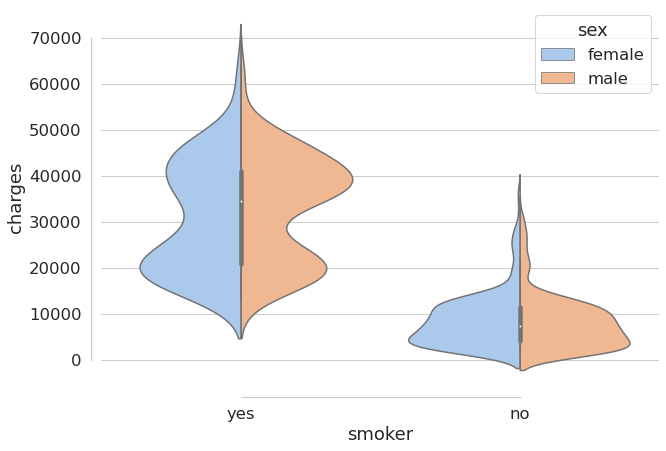

In [13]:
sns.violinplot(hue="sex", y='charges', x='smoker', 
               split=True, 
               palette='pastel', data=ins_data)
sns.despine(offset=10, trim=True)

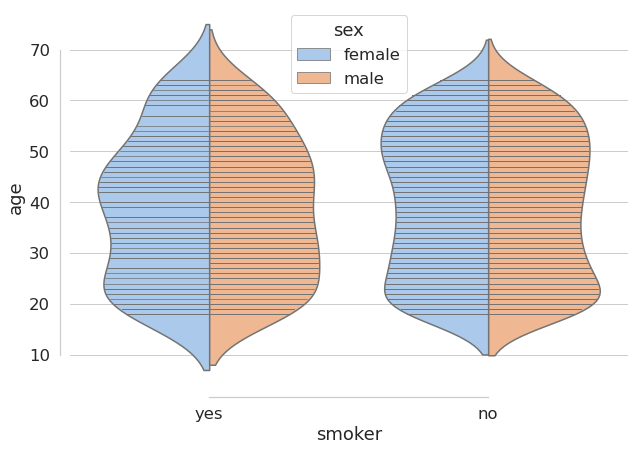

In [14]:
sns.violinplot(hue="sex", y='age', x='smoker', 
               split=True, inner="stick", 
               palette='pastel', data=ins_data)
sns.despine(offset=10, trim=True)

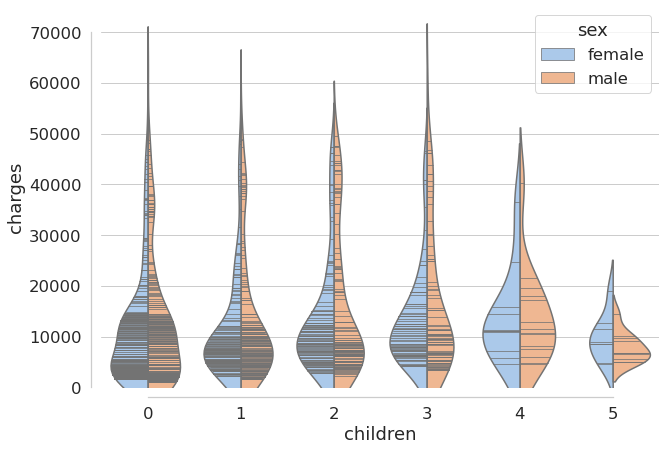

In [15]:
sns.violinplot(hue="sex", y='charges', x='children', 
               split=True, inner="stick", 
               palette='pastel', data=ins_data)
plt.ylim(0, 75000)
sns.despine(offset=10, trim=True)

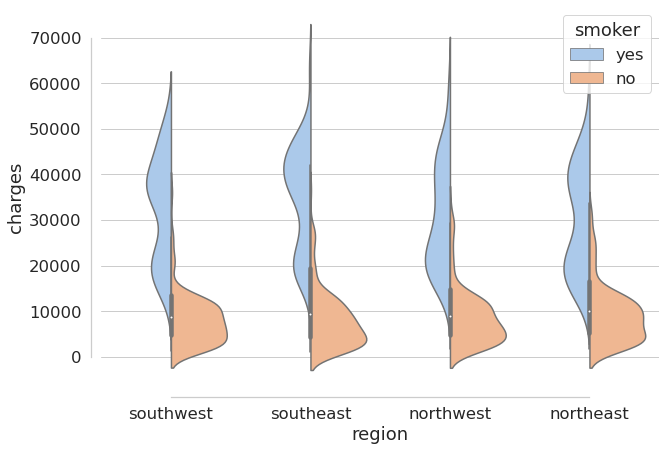

In [16]:
sns.violinplot(hue="smoker", y='charges', x='region', 
               split=True, 
               palette='pastel', data=ins_data)
sns.despine(offset=10, trim=True)

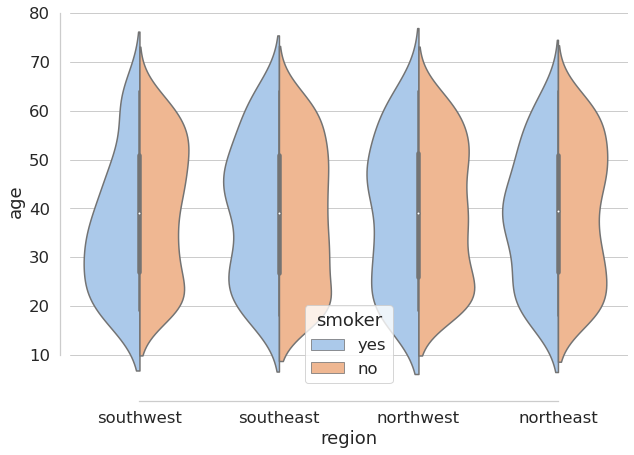

In [17]:
sns.violinplot(hue="smoker", y='age', x='region', 
               split=True, 
               palette='pastel', data=ins_data)
sns.despine(offset=10, trim=True)

In generall we can say that *region* is a balanced variable and may not affect our depending variable *charges*. It can be a good idea do not use *region* in our model.

<AxesSubplot:xlabel='region', ylabel='children'>

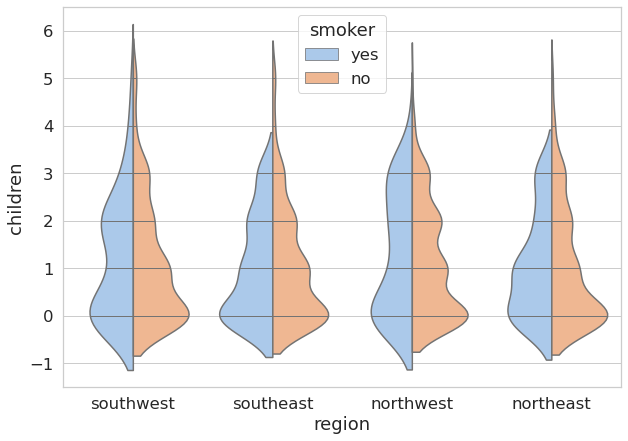

In [18]:
sns.violinplot(y='children', x='region', hue='smoker', 
               split=True, inner="stick", 
               palette='pastel', data=ins_data)

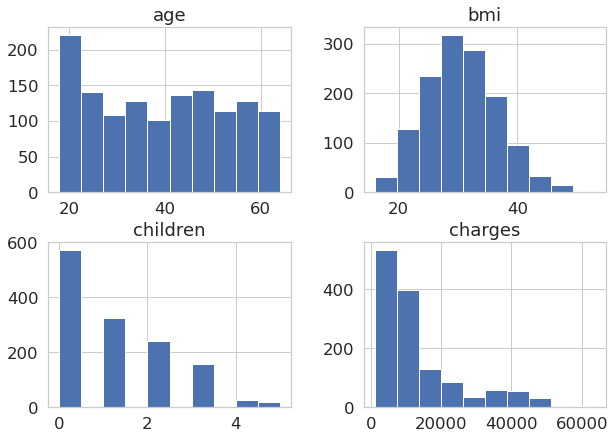

In [19]:
ins_data.hist()
plt.show()

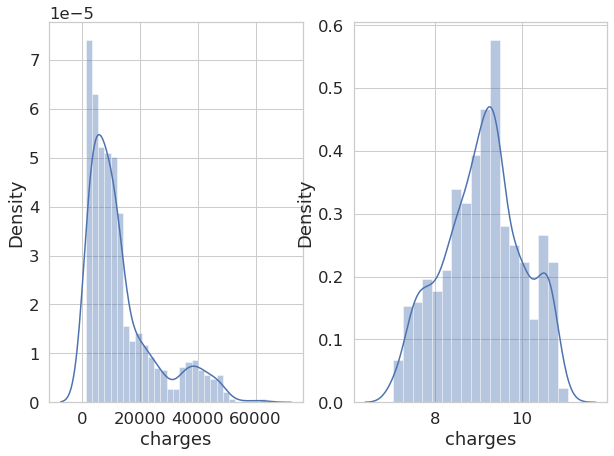

In [20]:
fig, axs = plt.subplots(1, 2)
sns.distplot(ins_data['charges'], ax=axs[0])
sns.distplot(np.log(ins_data['charges']), ax=axs[1])
plt.show()

So if we want to useboxplotnnear regression dependent variable must have normal distribution. So I will transform our dependent variable $charges$ with log transformation.

In [21]:
stats.normaltest(np.log(ins_data['charges']))

NormaltestResult(statistic=52.147628145443655, pvalue=4.745548606594116e-12)

As we can see even log transformation can't make our situation much more better, but we still can try to apply linear regression. 

<AxesSubplot:>

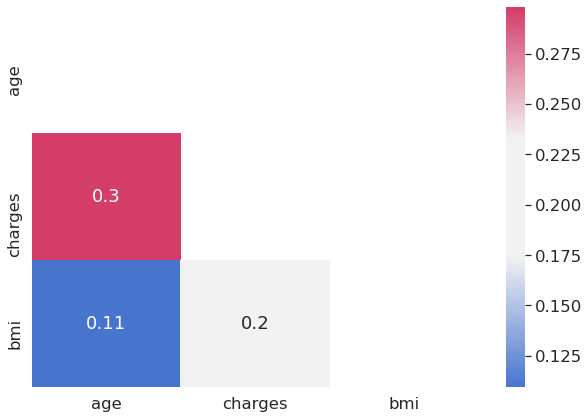

In [22]:
corr = ins_data.loc[:, ['age', 'charges', 'bmi']].corr()
mask = np.zeros_like(corr)
mask[np.tril_indices_from(mask)] = True
mask = np.ones((3, 3)) - mask + np.eye(3)
sns.heatmap(corr, cmap=sns.diverging_palette(256, 0, sep=80, as_cmap=True), annot=True, mask=mask)

Here we can see some correlations between our quantitative variables, especially in groups based on $smoker$ variable.

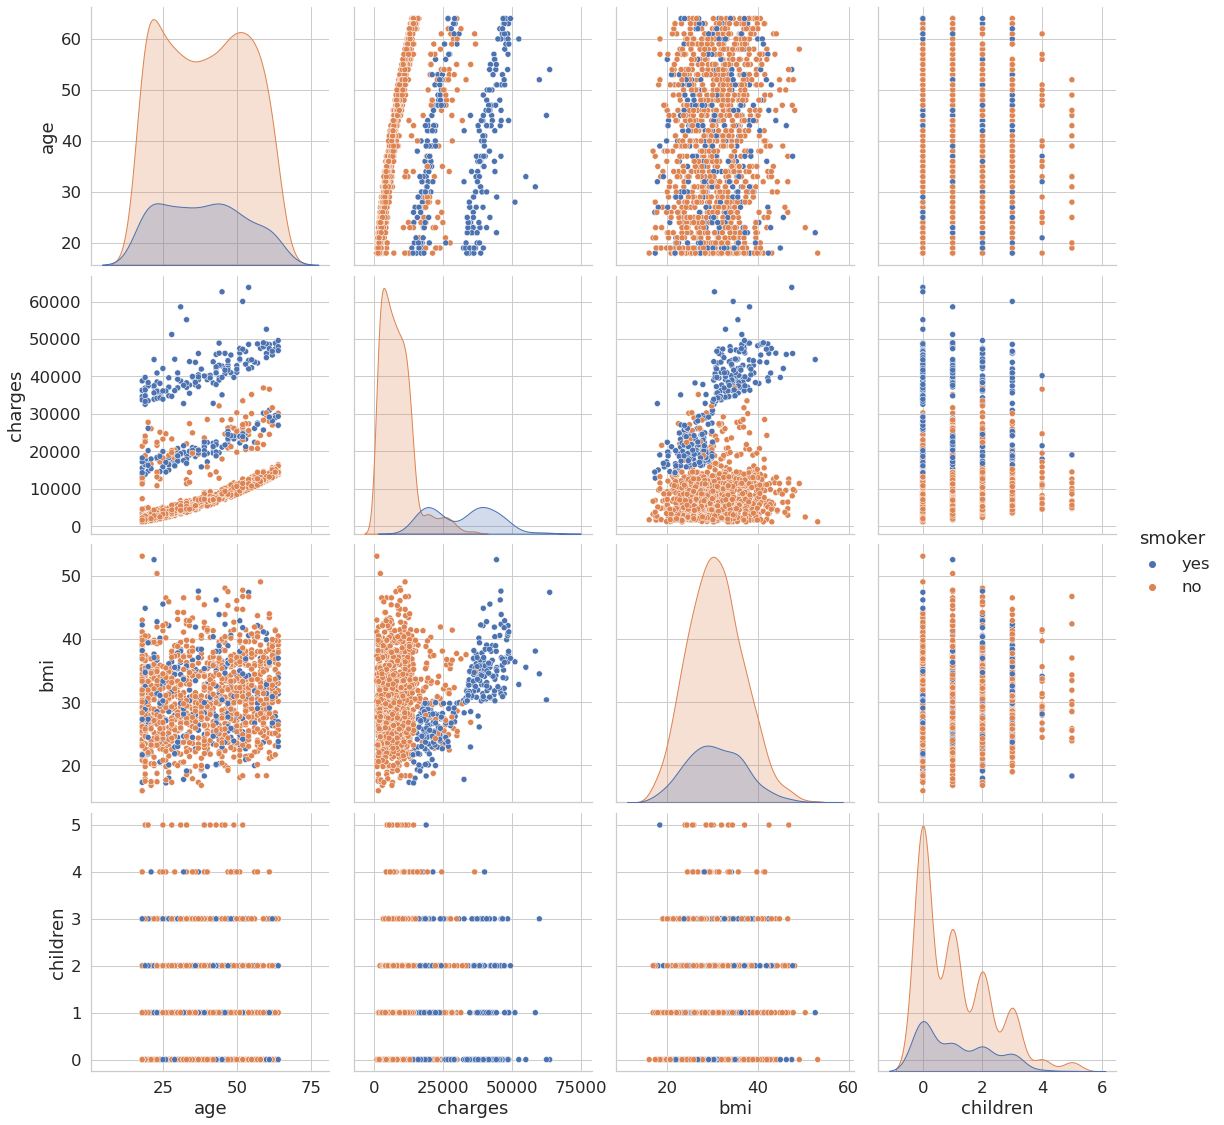

In [23]:
sns.pairplot(data=ins_data, height=4, hue='smoker', 
             x_vars=['age', 'charges', 'bmi', 'children'],
             y_vars=['age', 'charges', 'bmi', 'children'])

In [24]:
ins_data['log_charges'] = np.log(ins_data.charges)

In [25]:
ins_data.head()

age     sex     bmi  children smoker     region      charges  log_charges
0   19  female  27.900         0    yes  southwest  16884.92400     9.734176
1   18    male  33.770         1     no  southeast   1725.55230     7.453302
2   28    male  33.000         3     no  southeast   4449.46200     8.400538
3   33    male  22.705         0     no  northwest  21984.47061     9.998092
4   32    male  28.880         0     no  northwest   3866.85520     8.260197

# Lets dive into linear regression

Provide stratified train-test split to get balanced train and test data sets by $sex$ and $smoker$ vars.

In [26]:
ins_data['age'] = StandardScaler().fit_transform(ins_data['age'].values.reshape(-1, 1))
ins_data['bmi'] = StandardScaler().fit_transform(ins_data['age'].values.reshape(-1, 1))
ins_data['log_charges'] = StandardScaler().fit_transform(ins_data['log_charges'].values.reshape(-1, 1))

In [27]:
X = ins_data.drop(['charges', 'log_charges'], axis=1)
y = ins_data['log_charges']


X['age'] = StandardScaler().fit_transform(X['age'].values.reshape(-1, 1))
X['bmi'] = StandardScaler().fit_transform(X['age'].values.reshape(-1, 1))
y = StandardScaler().fit_transform(y.values.reshape(-1, 1))

le = LabelEncoder()

X_num = X.copy()
X_num['sex'] = le.fit_transform(X['sex'])
X_num['smoker'] = le.fit_transform(X['smoker'])
X_num['region'] = le.fit_transform(X['region'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=X[['sex', 'smoker']], random_state=1)

X_train = pd.get_dummies(X_train, columns=['sex', 'smoker','region'])
X_test = pd.get_dummies(X_test, columns=['sex', 'smoker','region'])

In [28]:
ins_data_numeric = ins_data.copy()
ins_data_numeric['smoker'] = ins_data['smoker'].map({'yes': 1, 'no': 0})
ins_data_numeric['sex'] = ins_data['sex'].map({'female': 1, 'male': 0})
ins_data_numeric['region'] = ins_data['region'].map({'southwest': 0, 'southeast': 1, 'northwest': 2, 'northeast': 3})
ins_data_numeric.head()

age  sex       bmi  children  smoker  region      charges  log_charges
0 -1.440418    1 -1.440418         0       1       0  16884.92400     0.690636
1 -1.511647    0 -1.511647         1       0       1   1725.55230    -1.793016
2 -0.799350    0 -0.799350         3       0       1   4449.46200    -0.761567
3 -0.443201    0 -0.443201         0       0       2  21984.47061     0.978014
4 -0.514431    0 -0.514431         0       0       2   3866.85520    -0.914386

## Multiple Linear Regression With scikit-learn

### Building a model

In [29]:
log_charges_lm = LinearRegression()
log_charges_lm.fit(X_train, y_train)

LinearRegression()

In [30]:
print(f'R^2 = {log_charges_lm.score(X_test, y_test)}')
print(f'R^2_adj = {calc_adj_r_sq(log_charges_lm, X_test, y_test)}')

R^2 = 0.7662061403172608
R^2_adj = 0.756160310409018


Lets try to create model without region variable.

In [31]:
X_wo_region_train = X_train.loc[:, ~X_train.columns.str.startswith('region')]
X_wo_region_test = X_test.loc[:, ~X_test.columns.str.startswith('region')]

In [32]:
log_charges_lm_2 = LinearRegression()
log_charges_lm_2.fit(X_wo_region_train, y_train)

LinearRegression()

In [33]:
print(f'R^2 = {log_charges_lm_2.score(X_wo_region_test, y_test)}')
print(f'R^2_adj = {calc_adj_r_sq(log_charges_lm_2, X_wo_region_test, y_test)}')

R^2 = 0.7655525793363925
R^2_adj = 0.7592405333954493


## Using Statmodel

Next i wiil use statmodels

In [34]:
X_train = sm.tools.add_constant(X_train)
X_test = sm.tools.add_constant(X_test)

In [35]:
full_model = sm.OLS(y_train, X_train).fit()
print(full_model.summary())

X_train_dropped = X_train.copy()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     475.7
Date:                Wed, 17 Mar 2021   Prob (F-statistic):          5.78e-322
Time:                        20:24:32   Log-Likelihood:                -749.32
No. Observations:                1069   AIC:                             1515.
Df Residuals:                    1061   BIC:                             1554.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1776      0.010  

#### Remove features with $p-value$ > 0.05

In [36]:
sing_features = select_sign_covs(full_model, X_train, y_train)
trimmed_model = sm.OLS(y_train, sing_features).fit()
trimmed_model.summary()

Dropping region_southeast and running regression again because pvalue is: 0.7623327574067469
Dropping region_southwest and running regression again because pvalue is: 0.6223170972752516
Dropping region_northwest and running regression again because pvalue is: 0.2009906736933698
All p values less than 0.05


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.758
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     665.7
Date:                Wed, 17 Mar 2021   Prob (F-statistic):               0.00
Time:                        20:24:32   Log-Likelihood:                -750.27
No. Observations:                1069   AIC:                             1513.
Df Residuals:                    1063   BIC:                             1542.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1857      0.012     15.013      0.000       0.161       0.210
age                  0.2657      0.008     35.114      0.000       0.251       0.281
bmi                  0.2657      0.008     35.114      0.000       0.251       0.281
children             0.1049      0.012      8.453      0.000       0.081       0.129
sex_female           0.1344      0.016      8.180      0.000       0.102       0.167
sex_male             0.0513      0.016      3.195      0.001       0.020       0.083
smoker_no           -0.7675      0.017    -45.592      0.000      -0.801      -0.734
smoker_yes           0.9532      0.022     43.193      0.000       0.910       0.997
region_northeast     0.1060      0.035      3.009      0.003       0.037       0.175
==============================================================================
Omnibus:                      330.598   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1027.430
Skew:                           1.530   Prob(JB):                    7.88e-224
Kurtosis:                       6.701   Cond. No.                     1.02e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 4.3e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

We can see that there are now only signnificant predictors but $R^2_{adj}$ performace does not improved.

### Select only best features

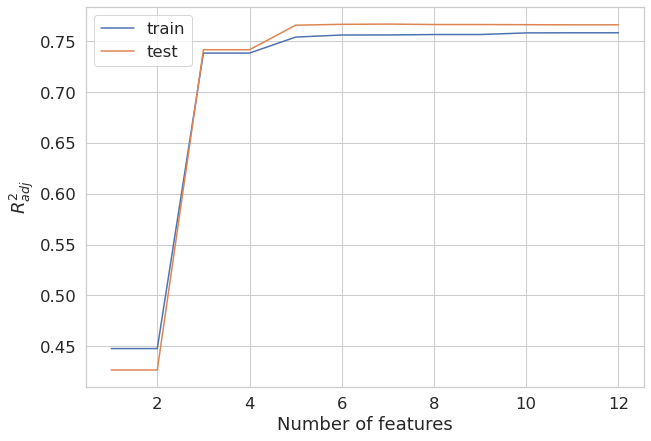

In [37]:
column_names = X_train.columns

no_of_features = []
r_squared_train = []
r_squared_test = []

max_features = X_train.shape[1]

for k in range(1, max_features + 1):
    selector = SelectKBest(f_regression, k = k)
    X_train_transformed = selector.fit_transform(X_train, y_train)
    X_test_transformed = selector.transform(X_test)
    regressor = LinearRegression()
    regressor.fit(X_train_transformed, y_train)
    no_of_features.append(k)
    r_squared_train.append(regressor.score(X_train_transformed, y_train))
    r_squared_test.append(regressor.score(X_test_transformed, y_test))
    
sns.lineplot(x = no_of_features, y = r_squared_train, label='train', legend='full')
sns.lineplot(x = no_of_features, y = r_squared_test, label='test', legend='full')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('$R^2_{adj}$')
plt.show()

In [38]:
best_no_features = r_squared_test.index(max(r_squared_test)) + 1
best_no_features

7

In [39]:
# Best score k = 7
selector = SelectKBest(f_regression, k = 7)
X_train_transformed = selector.fit_transform(X_train, y_train)
X_test_transformed = selector.transform(X_test)
column_names[selector.get_support()]

Index(['age', 'bmi', 'children', 'smoker_no', 'smoker_yes', 'region_northeast',
       'region_southwest'],
      dtype='object')

In [174]:
rf_r_sq = RandomForestRegressor().fit(X_train_transformed, y_train).score(X_test_transformed, y_test) 

In [159]:
result_model_sm = sm.OLS(y_train, X_train_transformed).fit()
sm_lm_r_sq = result_model_sm.rsquared_adj

In [155]:
n, p = X_train_transformed.shape

In [156]:
result_model_skl = LinearRegression().fit(X_train_transformed, y_train)
y_pred = result_model_skl.predict(X_test_transformed)
r2_skl = metrics.r2_score(y_test, y_pred)
r2_adj = 1 - (1 - r2_skl) * (n - 1) / (n - p - 1)
r2_adj

0.7653884562040097

In [175]:
result = pd.DataFrame({'Model': ['Random_Forest', 'Linear model'], '$R^2_{adj}$': [rf_r_sq, r2_adj]})
result

Model  $R^2_{adj}$
0  Random_Forest     0.785154
1   Linear model     0.765388

In [180]:
inter_data_train = X_tr.copy()
inter_data_test = X_te.copy()
inter_data_train['log_charges'] = y_tr
#inter_data_test['log_charges'] = y_te

In [198]:
inter_model = smf.ols('log_charges ~ (age + bmi + C(sex) + children + C(smoker) + region) ** 2', data=inter_data_train).fit()
inter_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_charges   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     303.3
Date:                Wed, 17 Mar 2021   Prob (F-statistic):               0.00
Time:                        23:52:39   Log-Likelihood:                -586.47
No. Observations:                1069   AIC:                             1207.
Df Residuals:                    1052   BIC:                             1292.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                     -0.2975      0.045     -6.651      0.000      -0.385      -0.210
C(sex)[T.1]                   -0.0919      0.052     -1.772      0.077      -0.194       0.010
C(smoker)[T.1]                 1.4995      0.069     21.643      0.000       1.364       1.635
C(sex)[T.1]:C(smoker)[T.1]     0.2340      0.065      3.584      0.000       0.106       0.362
age                            0.2954      0.014     21.097      0.000       0.268       0.323
age:C(sex)[T.1]                0.0319      0.013      2.430      0.015       0.006       0.058
age:C(smoker)[T.1]            -0.2521      0.016    -15.539      0.000      -0.284      -0.220
bmi                            0.2954      0.014     21.097      0.000       0.268       0.323
bmi:C(sex)[T.1]                0.0319      0.013      2.430      0.015       0.006       0.058
bmi:C(smoker)[T.1]            -0.2521      0.016    -15.539      0.000      -0.284      -0.220
children                       0.1483      0.023      6.557      0.000       0.104       0.193
C(sex)[T.1]:children          -0.0109      0.022     -0.506      0.613      -0.053       0.032
children:C(smoker)[T.1]       -0.1471      0.028     -5.252      0.000      -0.202      -0.092
region                        -0.0518      0.020     -2.537      0.011      -0.092      -0.012
C(sex)[T.1]:region            -0.0124      0.024     -0.527      0.598      -0.059       0.034
C(smoker)[T.1]:region          0.1426      0.030      4.805      0.000       0.084       0.201
age:bmi                       -0.0526      0.016     -3.345      0.001      -0.083      -0.022
age:children                  -0.0279      0.006     -4.779      0.000      -0.039      -0.016
age:region                     0.0220      0.006      3.682      0.000       0.010       0.034
bmi:children                  -0.0279      0.006     -4.779      0.000      -0.039      -0.016
bmi:region                     0.0220      0.006      3.682      0.000       0.010       0.034
children:region               -0.0121      0.010     -1.260      0.208      -0.031       0.007
==============================================================================
Omnibus:                      646.258   Durbin-Watson:                   2.067
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5382.047
Skew:                           2.755   Prob(JB):                         0.00
Kurtosis:                      12.511   Cond. No.                     3.04e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.88e-29. This might indicate that there are
strong multicollinearity problems or that the design matri

In [199]:
fitted = inter_model.predict(inter_data_test)
metrics.r2_score(y_te, fitted)

0.7937452696348128

In [200]:
ins_data_numeric

age  sex       bmi  children  smoker  region      charges  \
0    -1.440418    1 -1.440418         0       1       0  16884.92400   
1    -1.511647    0 -1.511647         1       0       1   1725.55230   
2    -0.799350    0 -0.799350         3       0       1   4449.46200   
3    -0.443201    0 -0.443201         0       0       2  21984.47061   
4    -0.514431    0 -0.514431         0       0       2   3866.85520   
...        ...  ...       ...       ...     ...     ...          ...   
1333  0.767704    0  0.767704         3       0       2  10600.54830   
1334 -1.511647    1 -1.511647         0       0       3   2205.98080   
1335 -1.511647    1 -1.511647         0       0       1   1629.83350   
1336 -1.297958    1 -1.297958         0       0       0   2007.94500   
1337  1.551231    1  1.551231         0       1       2  29141.36030   

      log_charges  label  
0        0.690636      2  
1       -1.793016      0  
2       -0.761567      0  
3        0.978014      3  
4       -0.914386      0  
...           ...    ...  
1333     0.183734      2  
1334    -1.525554      0  
1335    -1.855159      0  
1336    -1.627977      0  
1337     1.284891      3  

[1337 rows x 9 columns]

So the best $R^2_{adj}$ is 0.79 with full model with interactions, but mb it is harder to interprete it.

### Try to apply propensity score

In [215]:
log_regr_model = LogisticRegression().fit(ins_data_numeric[['age', 'sex', 'bmi', 'children', 'region']], ins_data_numeric['smoker'])

In [216]:
prop_score = log_regr_model.predict_proba(ins_data_numeric[['age', 'sex', 'bmi', 'children', 'region']])

In [230]:
weights = ins_data_numeric['smoker'] * 1 / prop_score[:, 1] + 1 / (1 - prop_score[:, 1]) * ins_data_numeric['smoker']

In [231]:
smf.wls('log_charges ~ (age + bmi + C(sex) + children + C(smoker) + region) ** 2', data=ins_data_numeric, weights=weights).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            log_charges   R-squared:                       0.183
Model:                            WLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     27.00
Date:                Thu, 18 Mar 2021   Prob (F-statistic):           3.03e-51
Time:                        00:06:32   Log-Likelihood:                   -inf
No. Observations:                1337   AIC:                               inf
Df Residuals:                    1325   BIC:                               inf
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.7139      0.017     41.285      0.000       0.680       0.748
C(sex)[T.1]                   -0.0205      0.021     -0.986      0.324      -0.061       0.020
C(smoker)[T.1]                 0.7139      0.017     41.285      0.000       0.680       0.748
C(sex)[T.1]:C(smoker)[T.1]    -0.0205      0.021     -0.986      0.324      -0.061       0.020
age                            0.0322      0.006      5.559      0.000       0.021       0.044
age:C(sex)[T.1]                0.0097      0.011      0.910      0.363      -0.011       0.031
age:C(smoker)[T.1]             0.0322      0.006      5.559      0.000       0.021       0.044
bmi                            0.0322      0.006      5.559      0.000       0.021       0.044
bmi:C(sex)[T.1]                0.0097      0.011      0.910      0.363      -0.011       0.031
bmi:C(smoker)[T.1]             0.0322      0.006      5.559      0.000       0.021       0.044
children                      -0.0083      0.009     -0.946      0.344      -0.026       0.009
C(sex)[T.1]:children          -0.0179      0.018     -0.968      0.333      -0.054       0.018
children:C(smoker)[T.1]       -0.0083      0.009     -0.946      0.344      -0.026       0.009
region                        -0.0343      0.008     -4.181      0.000      -0.050      -0.018
C(sex)[T.1]:region            -0.0191      0.020     -0.966      0.334      -0.058       0.020
C(smoker)[T.1]:region         -0.0343      0.008     -4.181      0.000      -0.050      -0.018
age:bmi                        0.0158      0.012      1.311      0.190      -0.008       0.039
age:children                   0.0056      0.005      1.129      0.259      -0.004       0.015
age:region                     0.0040      0.005      0.789      0.430      -0.006       0.014
bmi:children                   0.0056      0.005      1.129      0.259      -0.004       0.015
bmi:region                     0.0040      0.005      0.789      0.430      -0.006       0.014
children:region                0.0200      0.009      2.298      0.022       0.003       0.037
==============================================================================
Omnibus:                      161.261   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1552.845
Skew:                          -0.042   Prob(JB):                         0.00
Kurtosis:                       8.279   Cond. No.                     1.70e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.13e-30. This might indicate that there are
strong multicollinearity problems or that the design matri

So unfortunatelly it does not work at all, mb because $smoker$ does not depend on other variables in data.

### Cheking conditions of applicability

#### Cook's distances

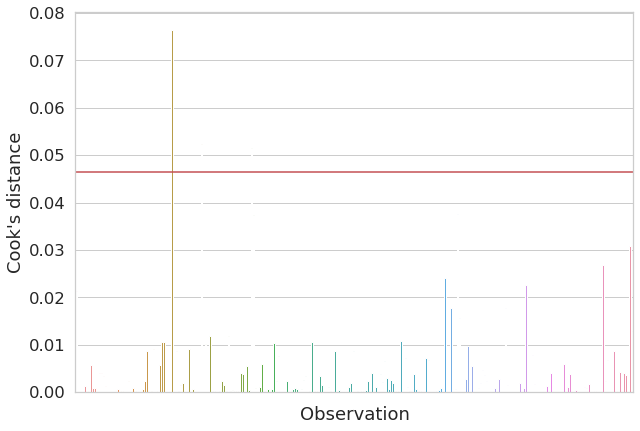

In [43]:
cooks_distances_stat_models(result_model, y_test)

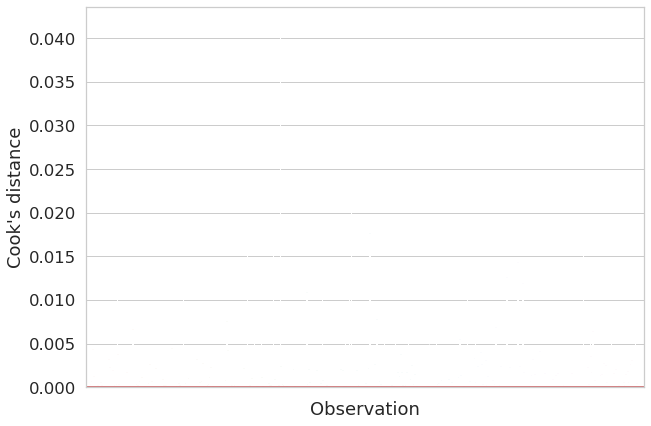

In [232]:
cooks_distances_stat_models(inter_model, ins_data_numeric['log_charges'])

#### Model residues

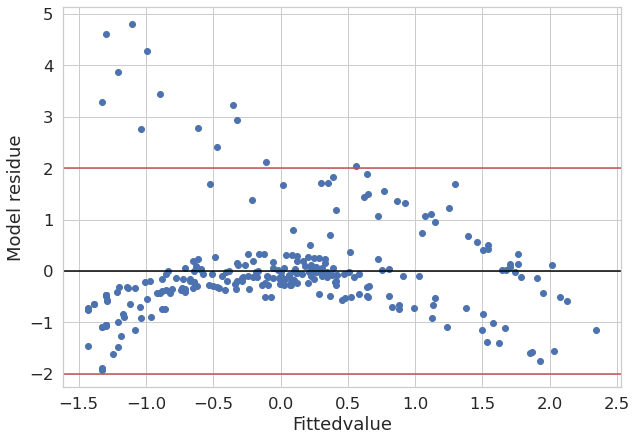

In [44]:
resid_distribution(result_model)

In [124]:
#inter_model = smf.ols('log_charges ~ (age + bmi + sex + children + smoker + region) ** 2 - sex:children - children:region - sex:region', data=ins_data_numeric).fit()
#inter_model.summary()

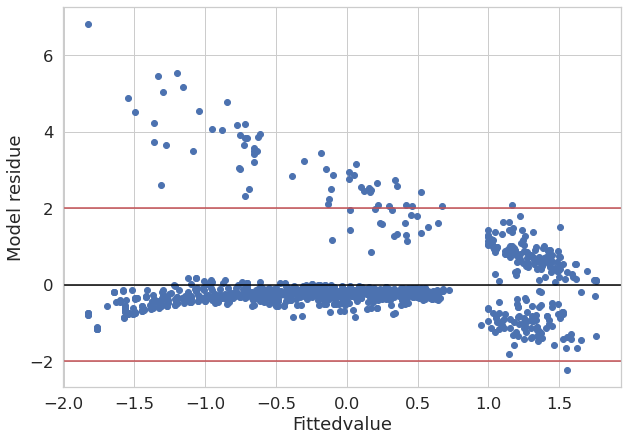

In [233]:
resid_distribution(inter_model)

In [133]:
le = LabelEncoder()

X_num = X.copy()
X_num['sex'] = le.fit_transform(X['sex'])
X_num['smoker'] = le.fit_transform(X['smoker'])
X_num['region'] = le.fit_transform(X['region'])
X_num

age  sex       bmi  children  smoker  region
0    -1.440418    0 -1.440418         0       1       3
1    -1.511647    1 -1.511647         1       0       2
2    -0.799350    1 -0.799350         3       0       2
3    -0.443201    1 -0.443201         0       0       1
4    -0.514431    1 -0.514431         0       0       1
...        ...  ...       ...       ...     ...     ...
1333  0.767704    1  0.767704         3       0       1
1334 -1.511647    0 -1.511647         0       0       0
1335 -1.511647    0 -1.511647         0       0       2
1336 -1.297958    0 -1.297958         0       0       3
1337  1.551231    0  1.551231         0       1       1

[1337 rows x 6 columns]

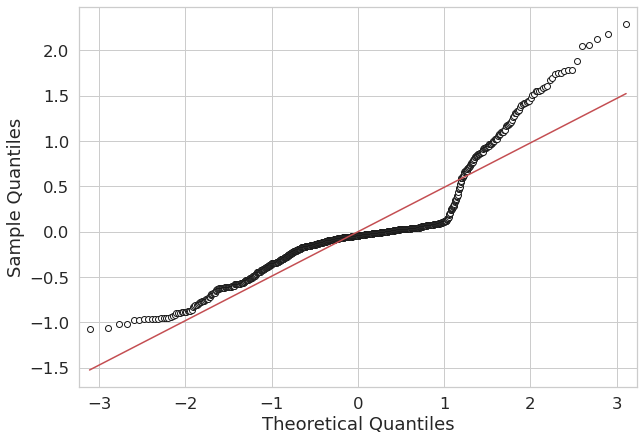

In [234]:
qqPlot(result_model.resid)

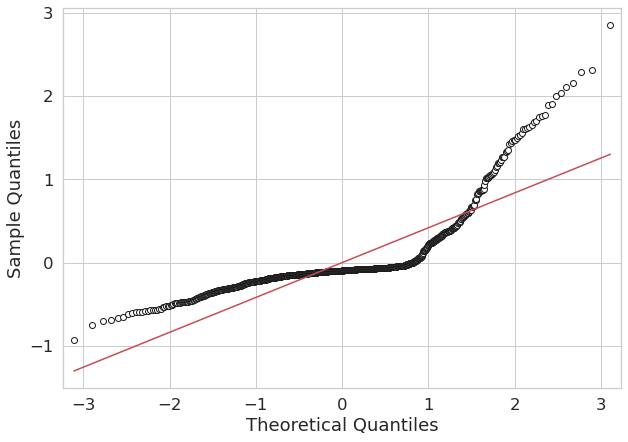

In [235]:
qqPlot(inter_model.resid)

Seems like situation is not pretty perfect for application of linear models. Especially in residues distriburion but there are a lot of observations so estimation of $t-statistics$ might be robust.

## Lets try to find some silent variable

Here we can see that in our data some silent dependences took its place.
I think it may be a good idea to cluster data and label observations with new variable. 
Then make a new model and check if it will be better. Unfortunatelly we cant apply rhis strategy to predict charges, but
we can clearify that model may be better if we put additional covariate in data set.

Here i tried some clustering algorithms, but KMeans and Agglomerative clustering perfrormed best results (and also pretty similar ones) so i decided to use only KMeans

Check if dummies affects KMeans

In [46]:
kmeans_1 = KMeans(n_clusters=3, random_state=1).fit(pd.get_dummies(ins_data, columns=['sex', 'smoker','region']))

In [47]:
kmeans = KMeans(n_clusters=3, random_state=1).fit(ins_data_numeric)

In [48]:
sum(kmeans_1.labels_ == kmeans.labels_) == len(kmeans.labels_)

True

So it does not affets

Lets see how many clusters do we need to take for KMeans

Text(0, 0.5, '$J(C_k)$')

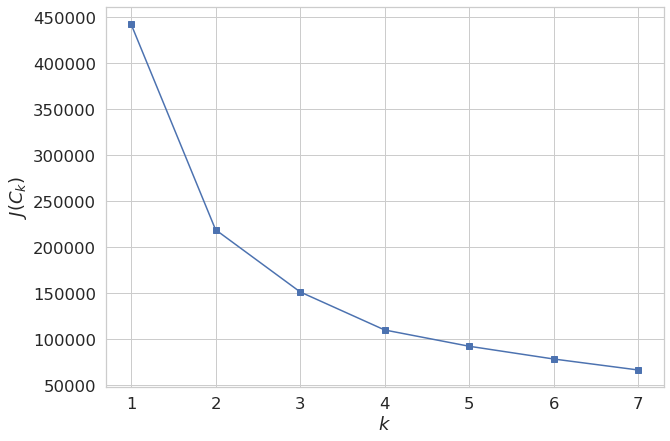

In [49]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(ins_data_numeric)
    inertia.append(np.sqrt(kmeans.inertia_))

plt.plot(range(1, 8), inertia, marker='s')
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$')

It can seems to be 2, 3 or even 4. Lets see on silhouette score.

Text(0, 0.5, '$Silhouette$')

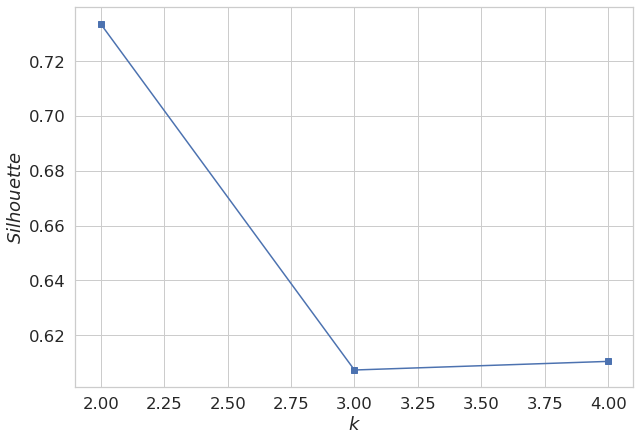

In [50]:
silhouette = []
for k in range(2, 5):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(ins_data_numeric)
    silh = metrics.silhouette_score(ins_data_numeric, kmeans.labels_)
    silhouette.append(silh)

plt.plot(range(2, 5), silhouette, marker='s')
plt.xlabel('$k$')
plt.ylabel('$Silhouette$')

As we can see 3 clusters for KMeans is the best way, but we ckeck 2 and 4 too. Lets label our data, run PCA and see how our labels could color PCA plot.

In [51]:
kmeans_2 = KMeans(n_clusters=2, random_state=1).fit(ins_data_numeric)
kmeans_3 = KMeans(n_clusters=3, random_state=1).fit(ins_data_numeric)
kmeans_4 = KMeans(n_clusters=4, random_state=1).fit(ins_data_numeric)
ins_data_numeric['label'] = kmeans_3.labels_

Projecting 9-dimensional data to 2D


Text(0.5, 1.0, 'MNIST. PCA projection')

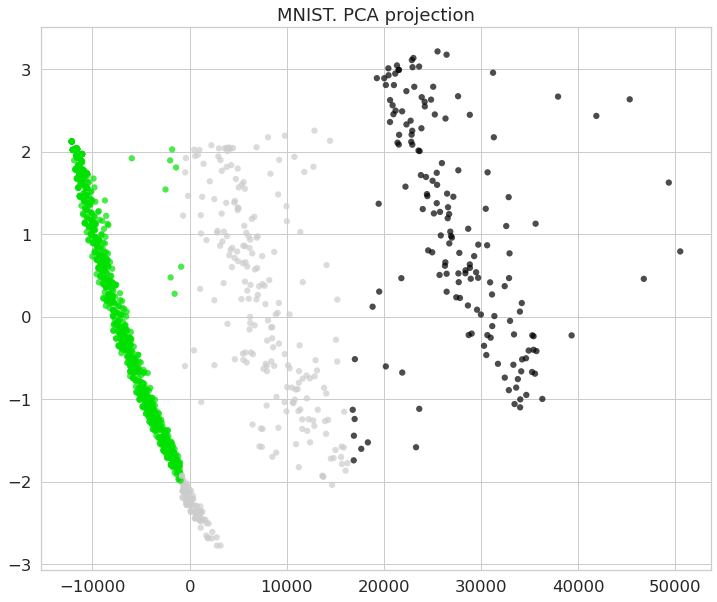

In [52]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(ins_data_numeric)

print('Projecting %d-dimensional data to 2D' % ins_data_numeric.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=kmeans_3.labels_, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.title('MNIST. PCA projection')

Does not look perfect but it is nice. Lets see on $R^2_{adj}$

In [53]:
ins_data_numeric['label'] = kmeans_2.labels_
X_t = ins_data_numeric.drop(['charges', 'log_charges'], axis=1)
y_t = ins_data_numeric['log_charges']
mod = LinearRegression().fit(X_t, y_t)
mod.score(X_t, y_t)

0.8080303586973344

In [54]:
ins_data_numeric['label'] = kmeans_3.labels_
X_t = ins_data_numeric.drop(['charges', 'log_charges'], axis=1)
y_t = ins_data_numeric['log_charges']
mod = LinearRegression().fit(X_t, y_t)
mod.score(X_t, y_t)

0.7603229360099242

In [55]:
ins_data_numeric['label'] = kmeans_4.labels_
X_t = ins_data_numeric.drop(['charges', 'log_charges'], axis=1)
y_t = ins_data_numeric['log_charges']
mod = LinearRegression().fit(X_t, y_t)
mod.score(X_t, y_t)

0.7997347791002039

$R^2_{adj}$ tells us that 2 clusters is the best. So 2 or 3 clusters may be a reall features of our data, I think this variable may reflect the life lelvel (low, middle or high)